In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.autograd
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import gym
from collections import deque
import random
import sys
import pandas as pd
import matplotlib.pyplot as plt
from numpy import cos, sin
from gym import spaces
from gym.error import DependencyNotInstalled
from typing import Optional
from control.matlab import ss, lsim, linspace, c2d
from functools import partial
# from state_estimation import Estimator
import math
import gym
from stable_baselines3 import PPO, SAC, TD3, DDPG, DQN, A2C
from stable_baselines3.common.env_checker import check_env

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [15]:
class DCEnv(gym.Env):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }

    def __init__(self, render_mode: Optional[str] = None, g=10.0):
        super(DCEnv, self).__init__()
        self.max_speed = -10
        self.max_torque = 10
        self.dt = 0.05

        self.render_mode = render_mode

        self.screen_dim = 500
        self.screen = None
        self.clock = None
        self.isopen = True
        self.center = np.array([math.pi / 3.0 * 2, 0, 0])
        self.obstacle = np.array([[math.pi / 4.0, 0, 0], [math.pi / 8.0, 0, 0]])
        
        count = 0
        J = 0.01
        b = 0.1
        K = 0.01
        R = 1
        L = 0.5
        self.A = np.array([[0, 1, 0],
         [0, -b / J, K / J],
         [0, -K / L, -R / L]])
        self.A_dim = len(self.A)
        self.B = np.array([[0], [0], [1 / L]])
        self.xmeasure = 0
        self.attacked_element_idx = 0
        self.C = np.array([[1, 0, 0]])
        self.D = np.array([[0]])
        self.Q = np.eye(self.A_dim)
        self.R = np.array([[1]])
        self.dt = 0.2
        self.x_ref = np.array([[0], [0], [0]]) # 4th dim is remaining steps
        # store current trace
        self.cache1 = []
        self.cache2 = []
        self.cache3 = []
        self.x0 = np.copy(self.x_ref)
        self.u_upbound_tuned = np.array([[10]])
        # ball radius
        self.target_norm_radius = 0.6 # norm ball radius of target, tune this
        self.safe_norm_radius = 0.5 # norm ball radius of safe, tune this
        self.total_time = 120
        # step number
        self.steps = 0
        self.u_lowbound = None
        # store training traces
        self.state_array_1 = []
        self.state_array_2 = []
        self.state_array_3 = []
        self.caches = []
        self.reward_cache = [] # cache distances to target norm ball center
        self.avoid_reward_cache = [] # cache distances to obstacles norm ball center
        self.final_reward_cache = [] # cache final reward
        # How long should this trace be, i.e. deadline
        self.step_const = 50
        # Maximum reward from each trace
        self.max_reward_list = []
        self.quality_list = []
        self.total_steps = 0
        self.step_history = []
        self.sysc = ss(self.A, self.B, self.C, self.D)
        self.sysd = c2d(self.sysc, self.dt)
        
        high = np.array(self.x_ref.flatten(), dtype=np.float32)
        self.action_space = spaces.Box(
            low=-self.max_torque, high=self.max_torque, shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)
        self.reached = False
        self.k = 20
    def step(self, u):
        
        # simulate next step and get measurement
        self.steps += 1
        self.total_steps += 1
        terminated = False
        dt = self.dt
        u = np.clip(u, -self.max_torque, self.max_torque)[0]
        self.last_u = u 
        costs = 1
        yout, T, xout = lsim(self.sysc, self.last_u, [0, self.dt], self.xmeasure)
        self.xmeasure = xout[-1]
        
        # calculate euclidean distance and update reward cache
        dist = np.linalg.norm(self.xmeasure - self.center)
        state = self.xmeasure
        obs_dist = min(np.linalg.norm(state[:3] - self.obstacle[0]), np.linalg.norm(state[:3] - self.obstacle[1]))
        reward = self.target_norm_radius - dist
        obs_reward = obs_dist-self.safe_norm_radius
        
        self.reward_cache.append(reward)
        self.avoid_reward_cache.append(obs_reward)
        # quantitative semantics
        # reach reward, encourage reaching target
        if self.steps < 10:
            reach_reward = max(self.reward_cache)
        else:
            reach_reward = max(self.reward_cache[-10:])
        if self.steps < 10:
            avoid_reward = min(self.avoid_reward_cache)
        else:
            avoid_reward = min(self.avoid_reward_cache[-10:])          
                    
#         # very strict reward, always within target
#         strict_avoid_reward = avoid_reward - 0.5 * self.safe_norm_radius # half safe norm radius
#         strict_reach_reward = reach_reward - 0.5 * self.target_norm_radius # half target norm radius
        
        # overall reward, pick one of the final_reward
#         final_reward = reach_reward
#         final_reward = approach_reward
        final_reward = min(reach_reward, avoid_reward) # reach and avoid
#         final_reward = min(approach_reward, avoid_reward) # approach and avoid
#         final_reward = min(reach_reward, approach_reward) # reach and approach
#         deadline_reward = (self.last_dist-dist)/(self.step_const - self.steps+1) 
#         final_reward = reach_reward
        # split cases: if already inside target, give very large constant reward for maintaining
        if dist <= self.target_norm_radius:
            final_reward = 10 # this gives 39/50 sucess with reach+approach+avoid
        
        self.final_reward_cache.append(final_reward)
        
        # update cached memory
        self.state = self.xmeasure
        self.state_array_1.append(self.state[0])
        self.state_array_2.append(self.state[1])
        self.state_array_3.append(self.state[2])
        self.cache1.append(self.state[0])
        self.cache2.append(self.state[1])
        self.cache3.append(self.state[2])
        self.last_dist = dist
        # If this is the last step, reset the state
        if self.steps == self.step_const or obs_dist<=self.safe_norm_radius:
            self.max_reward_list.append(max(self.final_reward_cache)) # use max final reward to measure episodes
            self.step_history.append(self.total_steps)
            self.quality_list.append(sum(self.final_reward_cache))
            terminated = True
            # self.reset()
            
#         # If within target norm ball, early terminate
#         if dist <= self.target_norm_radius:
#             terminated = True
#             self.reset()
        
        # Return next state, reward, done, info
        return self._get_obs(), final_reward, terminated, {}
        
    def reset(self):
        self.state = np.array([random.random()*math.pi - 1, random.random()*2-1, random.random()*20-10])
        self.reward_cache = []
        self.final_reward_cache = []
        self.steps=0
        self.caches.append(self.cache1)
        self.caches.append(self.cache2)
        self.caches.append(self.cache3)
        self.cache1 = []
        self.cache2 = []
        self.cache3 = []
        self.xmeasure = self.state
        # random # of steps for this trace
        self.step_const = self.k # deadline range
        self.reached = False
        return np.array(self.state) # return something matching shape
    
    def _get_obs(self):
        current_state = list(self.state)
        return np.array(current_state)
    
    def render(self):
        return
    
    def close(self):
        if self.screen is not None:
            import pygame
            pygame.display.quit()
            pygame.quit()
            self.isopen = False

In [272]:
reached = []
env = DCEnv()
# model = A2C.load('surro_A2C_motor_1.zip', env=env)
for k in [10]:
    env = DCEnv()
    env.k = k
    print('Start training with PPO ...')
    # learning_rate = 1e-3, n_steps = 1024, tune these
    model = SAC("MlpPolicy", env, verbose=0)
    model.learn(total_timesteps=1000000, progress_bar=False)
    vec_env = model.get_env()
    obs = vec_env.reset()
    env = DCEnv()
#     env.k = 160
    state = env.reset()
    dims0 = []
    dims1 = []
    dims2 = []
    euclids = []
    center = env.center
#     obstacle = np.array([math.pi / 4.0, 0, 0])
    obstacle = env.obstacle
    num_reached = 0
    for j in range(1000):
        dim0 = []
        dim1 = []
        dim2 = []
        euclid = []
        state = env.reset()
        # Print initial state
        for i in range(50):
            action, _states = model.predict(state, deterministic=True)
            new_state, reward, done, _ = env.step(action)
            dim0.append(state[0])
            dim1.append(state[1])
            dim2.append(state[2])
            dist = np.linalg.norm(state[:3]-center)
            obs_dist = min(np.linalg.norm(state[:3] - obstacle[0]), np.linalg.norm(state[:3] - obstacle[1]))
            euclid.append(dist)
            state = new_state
            if obs_dist <= env.safe_norm_radius:
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                break
            if done:
                env.reset()
        dims0.append(dim0)
        dims1.append(dim1)
        dims2.append(dim2)
        euclids.append(euclid)
    reached.append(num_reached)
#     print("Total number reached = " + str(num_reached))
print(reached)

Start training with PPO ...
[835]


In [273]:
model.save('surro_SAC_1.zip')
# model.save('SAC_motor_1.zip')
# 

In [103]:
# Test 50 traces

env = DCEnv()
model = SAC.load("SAC_motor_1.zip", env=env)
state = env.reset()
dims0 = []
dims1 = []
dims2 = []
euclids = []
center = env.center
obstacle = env.obstacle
# print(obstacle[0])
num_reached = 0
num_vio= 0 
for j in range(1000):
    dim0 = []
    dim1 = []
    dim2 = []
    euclid = []
    state = env.reset()
    # Print initial state
    for i in range(50):
        action, _states = model.predict(state, deterministic=True)
        new_state, reward, done, _ = env.step(action)
        dim0.append(state[0])
        dim1.append(state[1])
        dim2.append(state[2])
        dist = np.linalg.norm(state[:3]-center)
        obs_dist = min(np.linalg.norm(state[:3]-obstacle[0]), np.linalg.norm(state[:3]-obstacle[1]))
        euclid.append(dist)
        state = new_state
        if obs_dist <= env.safe_norm_radius:
            num_vio += 1
            break
        if dist <= env.target_norm_radius: # stop
            num_reached += 1
            break
        if done:
            env.reset()
    dims0.append(dim0)
    dims1.append(dim1)
    dims2.append(dim2)
    euclids.append(euclid)
ref= [math.pi/2]*30
print("Total number reached = " + str(num_reached))
print("Total number vio = " + str(num_vio))


Total number reached = 846
Total number vio = 58


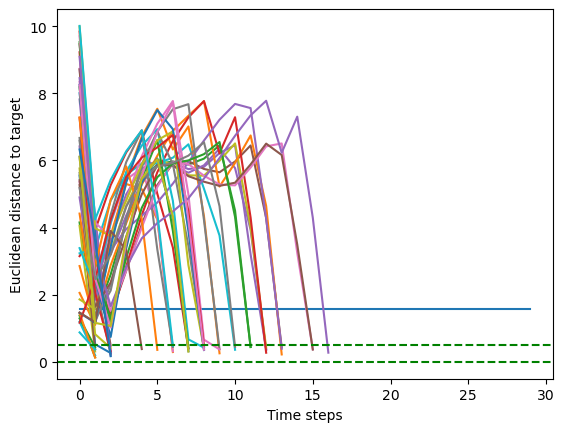

In [14]:
plt.plot(ref)
for i in range(50):
    plt.plot(euclids[i])
plt.axhline(y=0.5, color='g', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')
plt.plot()
plt.xlabel('Time steps')
plt.ylabel('Euclidean distance to target')
plt.show()

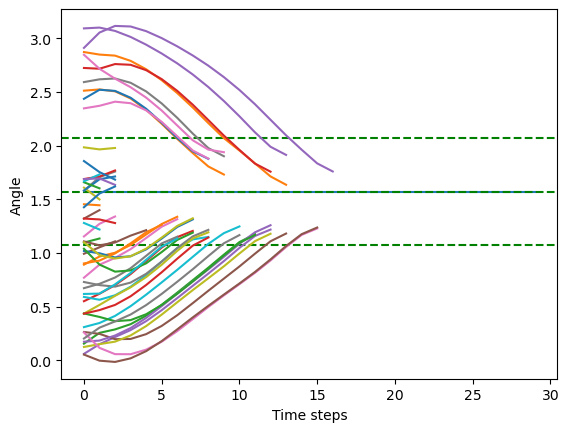

In [15]:
plt.plot(ref)
plt.axhline(y=1.07, color='g', linestyle='--')
plt.axhline(y=1.57, color='g', linestyle='--')
plt.axhline(y=2.07, color='g', linestyle='--')
for i in range(50):
    plt.plot(dims0[i])
plt.plot()
plt.xlabel('Time steps')
plt.ylabel('Angle')
plt.show()

In [16]:
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Max Overall Reward')
plt.show()

NameError: name 'reward_history' is not defined

In [4]:
# import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds, LinearConstraint, NonlinearConstraint, root
def fgsm_attack(state, model, epsilon, policy, norm, args):
    state = torch.from_numpy(state)
    state = state.detach().unsqueeze(0).requires_grad_(True)
    action = model.predict(state)
    # target = torch.argmax(q_vals).unsqueeze(0)
    # preds = torch.softmax(q_vals, 1)
    # The loss is calcualted with cross entropy
    # current_q = self.critic(state, action)
    # cri = model.critic(state)
    q_vals = (model.critic(state, action))
    loss = (q_vals[0] + q_vals[1]) / 2 * (-1)
    # print(target)
    # loss_func = torch.nn.CrossEntropyLoss()
    # loss = loss_func(preds, target)
    model.policy.zero_grad()
    
    loss.backward()
   
    state_grad = state.grad.detach().squeeze()
    
    state = state.squeeze()
    # Perturb only agent position and ball position
    if norm == float('inf'):
        perturbed_state = state + epsilon * state_grad.sign()
    elif norm == 2:
        perturbed_state = state + epsilon * state_grad / torch.norm(state_grad, norm)
    elif norm == 1:
        index = torch.argmax(state_grad)
        per = torch.zeros_like(state_grad)
        per[index] = 1
        perturbed_state = state + epsilon * per
    return perturbed_state.detach().cpu().numpy()

def white_attack(env, state, model,surro_model, adv_model, epsilon):
    action = model.predict(state, deterministic=True)[0]
    # print(action)
    effect = None
    attack = None
    _action = action
    _state = state
    state_range = np.array([epsilon])


    def fun(x):
        return min(np.linalg.norm( env.sysd.A @ _state + env.sysd.B @ x - env.obstacle[0]), 
                   np.linalg.norm( env.sysd.A @ _state + env.sysd.B @ x - env.obstacle[1]))  
    
    x_start = np.array(action)
    lim = [-10, 10]

    bounds = Bounds(lim[0], lim[1])  

#     x_state = odeint(bicycle, state, ts, args=(action,))[-1]
#     non_linear_eq= lambda x: np.linalg.norm(odeint(bicycle, state, ts, args=(x,))[-1] - env.obstacle) -\
#                             np.linalg.norm(odeint(bicycle, state, ts, args=(action,))[-1] - env.obstacle)
#     non_linear_constr = NonlinearConstraint(non_linear_eq, 0.0, np.inf)
#     result = minimize(fun, x_start, method='trust-constr', bounds=bounds, constraints=non_linear_constr)
    result = minimize(fun, x_start, method='trust-constr', bounds=bounds)
    # print(result.x)
    op_action = (result.x)
    state = torch.from_numpy(state)
    
    state = state.detach().unsqueeze(0).requires_grad_(True)
    # print(model.predict(state, deterministic=True)[0])
    # next_origin_obs_dist = min(np.linalg.norm( env.sysd.A @ _state + env.sysd.B @ _action - env.obstacle[0]), 
    #                            np.linalg.norm( env.sysd.A @ _state + env.sysd.B @ _action - env.obstacle[1]))
    effect = 1000

    for i in range(20):
        
        action = model.policy._predict(state, deterministic=True)[0].requires_grad_(True)
        action = action * 10
        action = action.double().requires_grad_(True)
        # print(action)
        # compute the distance
        loss = (torch.tensor([op_action]) - action).pow(2).sqrt()
        
        # loss = mse(torch.tensor([op_action]).requires_grad_(True), action)
        model.policy.zero_grad()
        loss = loss.double()
        # print(action.dtype)
        loss.backward()
        
        state_grad = state.grad.detach().squeeze()
        # print(loss)
        perturbed_state = state - state_grad.sign() * epsilon * 0.1
        # print(perturbed_state)
        l =  torch.from_numpy(_state) - torch.from_numpy(state_range)
        u = torch.from_numpy(_state) +  torch.from_numpy(state_range)
        perturbed_state = torch.max(torch.min(perturbed_state, u), l)
        # print(perturbed_state)
        # print('++++++++++')
        # print(action_next.detach().numpy()
        state = perturbed_state.detach().requires_grad_(True)
        # print(f'state:{perturbed_state}')
        # print(f'action:{_action}, op_action:{op_action}')
        dist = np.linalg.norm(_state - env.center)
        obs_dist = min(np.linalg.norm(_state - env.obstacle[0]), np.linalg.norm(_state - env.obstacle[1]))
        pertub_dist = np.linalg.norm(state.detach().numpy() - env.center)
        # pertub_obs_dist = np.linalg.norm(state.detach().numpy() - env.obstacle)
#         print(action_next)
#         next_obs_dist =  np.linalg.norm(odeint(bicycle, state.detach()[0], ts, args=(action_next.detach(),))[-1] - env.obstacle)
        if pertub_dist <= dist:
            # 
            if loss <= effect:
                effect = loss
                # print(effect)
                attack = (state.detach().numpy() - _state)[0]
    # print('+++++++++')
    if attack is None:
        return np.zeros_like(_state)
    else:
        # print(attack)
        return attack
        
  


In [252]:
# white box
norm = float('inf')
res_list = []
policy = None
args = None
env = DCEnv()
model = SAC.load("SAC_motor_1.zip", env=env)
clean_env = DCEnv()
state = env.reset()
dims0 = []
dims1 = []
dims2 = []
euclids = []
obs_dists = []
obs_dists_list = []
dist_list = []
center = env.center
obstacle =  env.obstacle
# print(env.center)
num_reached = 0
action_list = []
pertub_action_list = [] 
number_violate = 0
clean_obs_dists = []
clean_obs_dists_list = []
clean_num_reached = 0
clean_number_violate = 0
clean_obs_dist_list = []
clean_dist_list = []
for epsilon in [0.1, 0.2, 0.3, 0.4, 0.5]:
    num_reached = 0
    number_violate = 0

    for j in range(100):
        dim0 = []
        dim1 = []
        dim2 = []
        euclid = []
        state = env.reset()
        clean_state = clean_env.reset()
        for i in range( env.step_const):
          
            # action = model.predict(state, deterministic=True)
            # pertub_action = safe_attack(env, state, model, epsilon, policy, norm, args)
            attack = white_attack(env, state, model,surro_model=None, adv_model=None,  epsilon=epsilon)
            # print(attack)
            pertub_state = state + attack
            # pertub_state = state
            # print(pertub_state, state)
            pertub_action = model.predict(pertub_state, deterministic=True)[0]
            # print(pertub_action)
            # new_state, reward, done, _ = env.step(pertub_action[0])
            new_state, reward, done, _ = env.step(pertub_action)
            state = new_state
            # new_state, reward, done, _ = env.step(action[0])
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            pertub_action_list.append(pertub_action[0])
            # action_list.append(action)
            
            obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                break
            if done:
                env.reset()
            
        # print(obs_dists)
        # print('++++++++++++++++')
        obs_dists_list.append(obs_dists)
        obs_dists = []
       
    
    ref= [math.pi/2]*30
    print(f'epsion:{epsilon}')
    print("Total number reached = " + str(num_reached))
    print("Total number violate = " + str(number_violate))
    print("+++++++++++++++++++++++++++++++++++")
    # print("average of obs dist= " + str(sum(obs_dist_list) / len(obs_dist_list)))
    res_list.append(num_reached)
# print("clean env for reference")
# print("Total number reached = " + str(clean_num_reached))
# print("Total number violate = " + str(clean_number_violate))
# print("average of obs dist= " + str(sum(clean_obs_dist_list) / len(clean_obs_dist_list)))

epsion:0.1
Total number reached = 77
Total number violate = 5
+++++++++++++++++++++++++++++++++++
epsion:0.2
Total number reached = 52
Total number violate = 10
+++++++++++++++++++++++++++++++++++
epsion:0.3
Total number reached = 41
Total number violate = 17
+++++++++++++++++++++++++++++++++++
epsion:0.4
Total number reached = 22
Total number violate = 44
+++++++++++++++++++++++++++++++++++


KeyboardInterrupt: 

IndexError: list index out of range

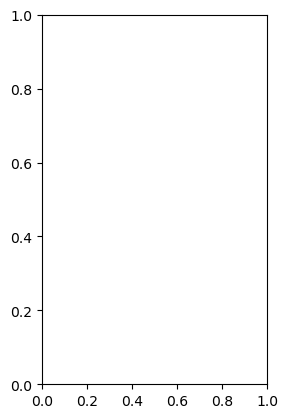

In [24]:
plt.subplot(1, 2, 1)
ave_dist = []
for i in range(10):
    ave_dist.append(sum(obs_dists_list[i]) / len(obs_dists_list[i]))
#     ave_dist.append(min(obs_dists_list[i]))
    # print(obs_dists_list[i])
    # plt.plot(np.arange(len(obs_dists_list[i])), obs_dists_list[i], color='red')
# print(ave_dist)
plt.boxplot(ave_dist)    
plt.ylim((-1, 8))   
plt.axhline(y=0.2, color='g', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')
plt.plot()
plt.xlabel('Time steps')
plt.ylabel('distance to unsafe', fontsize = 15)
plt.title('env being attacked')
# plt.show()


plt.subplot(1, 2, 2)
ave_dist = []
for i in range(10):
    ave_dist.append(sum(clean_obs_dists_list[i]) / len(clean_obs_dists_list[i]))
#     ave_dist.append(min(clean_obs_dists_list[i]))
    # plt.plot(np.arange(len(clean_obs_dists_list[i])), clean_obs_dists_list[i], color='green')
# print(ave_dist)
plt.boxplot(ave_dist)    
plt.ylim((-1, 8))       
plt.axhline(y=0.2, color='g', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')
plt.plot()
plt.xlabel('Time steps')
# plt.ylabel('obstacle distance')
plt.title('clean env')
plt.show()

In [276]:
#  train surrogate policy
reached = []

for k in [10]:
    env = DCEnv()
    env.k = k
    print('Start training with A2C ...')
    # learning_rate = 1e-3, n_steps = 1024, tune these
    surro_model = SAC("MlpPolicy", env, verbose=0)
    # surro_model = A2C.load('surro_A2C_motor_1.zip', env=env)
    surro_model.learn(total_timesteps=500000, progress_bar=False)
    vec_env = surro_model.get_env()
    obs = vec_env.reset()
    env = DCEnv()
    env.k = 160
    state = env.reset()
    dims0 = []
    dims1 = []
    dims2 = []
    euclids = []
    center = env.center
    obstacle = env.obstacle
    num_reached = 0
    for j in range(1000):
        dim0 = []
        dim1 = []
        dim2 = []
        euclid = []
        state = env.reset()
        # Print initial state
        for i in range(env.step_const):
            action, _states = surro_model.predict(state, deterministic=True)
            new_state, reward, done, _ = env.step(action)
            state = new_state
            dim0.append(state[0])
            dim1.append(state[1])
            dim2.append(state[2])
            dist = np.linalg.norm(state[:3]-center)
            obs_dist = min(np.linalg.norm(state[:3]-obstacle[0]), np.linalg.norm(state[:3]-obstacle[1]))
            euclid.append(dist)
            
            if obs_dist <= env.safe_norm_radius:
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                break
            if done:
                break
        dims0.append(dim0)
        dims1.append(dim1)
        dims2.append(dim2)
        euclids.append(euclid)
    reached.append(num_reached)
#     print("Total number reached = " + str(num_reached))
print(reached)

Start training with A2C ...
[658]


In [277]:
surro_model.save('surro_SAC_motor_1.zip')

In [5]:
class adv_DCEnv(gym.Env):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }

    def __init__(self, render_mode: Optional[str] = None, g=10.0):
        super(adv_DCEnv, self).__init__()
        self.max_speed = -10
        self.max_torque = 10
        self.dt = 0.05

        self.render_mode = render_mode

        self.screen_dim = 500
        self.screen = None
        self.clock = None
        self.isopen = True
        self.center = np.array([math.pi / 3.0 * 2, 0, 0])
        self.obstacle = np.array([[math.pi / 4.0, 0, 0], [math.pi / 8.0, 0, 0]])        
        count = 0
        J = 0.01
        b = 0.1
        K = 0.01
        R = 1
        L = 0.5
        self.A = np.array([[0, 1, 0],
         [0, -b / J, K / J],
         [0, -K / L, -R / L]])
        self.A_dim = len(self.A)
        self.B = np.array([[0], [0], [1 / L]])
        self.xmeasure = 0
        self.attacked_element_idx = 0
        self.C = np.array([[1, 0, 0]])
        self.D = np.array([[0]])
        self.Q = np.eye(self.A_dim)
        self.R = np.array([[1]])
        self.dt = 0.2
        self.x_ref = np.array([[0], [0], [0]]) # 4th dim is remaining steps
        # store current trace
        self.cache1 = []
        self.cache2 = []
        self.cache3 = []
        self.x0 = np.copy(self.x_ref)
        self.u_upbound_tuned = np.array([[10]])
        # ball radius
        self.target_norm_radius = 0.5 # norm ball radius of target, tune this
        self.safe_norm_radius = 0.2 # norm ball radius of safe, tune this
        self.total_time = 120
        # step number
        self.steps = 0
        self.u_lowbound = None
        # store training traces
        self.state_array_1 = []
        self.state_array_2 = []
        self.state_array_3 = []
        self.caches = []
        self.reward_cache = [] # cache distances to target norm ball center
        self.avoid_reward_cache = [] # cache distances to obstacles norm ball center
        self.final_reward_cache = [] # cache final reward
        # How long should this trace be, i.e. deadline
        self.step_const = random.randint(10, 50)
        # Maximum reward from each trace
        self.max_reward_list = []
        self.quality_list = []
        self.total_steps = 0
        self.step_history = []
        self.sysc = ss(self.A, self.B, self.C, self.D)
        self.sysd = c2d(self.sysc, self.dt)
        
        high = np.array(self.x_ref.flatten(), dtype=np.float32)
        self.action_space = spaces.Box(
            low=-self.max_torque, high=self.max_torque, shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)
        self.reached = False
        self.k = 20
    def step(self, u):
        
        # simulate next step and get measurement
        self.steps += 1
        self.total_steps += 1
        terminated = False
        dt = self.dt
        u = np.clip(u, -self.max_torque, self.max_torque)[0]
        self.last_u = u 
        costs = 1
        yout, T, xout = lsim(self.sysc, self.last_u, [0, self.dt], self.xmeasure)
        self.xmeasure = xout[-1]
        
        # calculate euclidean distance and update reward cache
        dist = np.linalg.norm(self.xmeasure - self.center)
        obs_dist = min(np.linalg.norm(state[:3] - obstacle[0]), np.linalg.norm(state[:3] - obstacle[1]))
#         reward = self.target_norm_radius - dist
        obs_reward = obs_dist-self.safe_norm_radius
        obs_reward = -obs_reward
#         self.reward_cache.append(reward)
        self.avoid_reward_cache.append(obs_reward)
        # quantitative semantics
        # reach reward, encourage reaching target
#         if self.steps < 10:
#             reach_reward = max(self.reward_cache)
#         else:
#             reach_reward = max(self.reward_cache[-10:])
        if self.steps < 10:
            avoid_reward = max(self.avoid_reward_cache)
        else:
            avoid_reward = max(self.avoid_reward_cache[-10:])   
        final_reward = avoid_reward
   
        if obs_dist <= self.safe_norm_radius:
            final_reward = 10
        self.final_reward_cache.append(final_reward)
        
        # update cached memory
        self.state = self.xmeasure
        self.state_array_1.append(self.state[0])
        self.state_array_2.append(self.state[1])
        self.state_array_3.append(self.state[2])
        self.cache1.append(self.state[0])
        self.cache2.append(self.state[1])
        self.cache3.append(self.state[2])
        self.last_dist = dist
        # If this is the last step, reset the state
        if self.steps == self.step_const or obs_dist<=self.safe_norm_radius:
            self.max_reward_list.append(max(self.final_reward_cache)) # use max final reward to measure episodes
            self.step_history.append(self.total_steps)
            self.quality_list.append(sum(self.final_reward_cache))
            terminated = True
            self.reset()
            
#         # If within target norm ball, early terminate
#         if dist <= self.target_norm_radius:
#             terminated = True
#             self.reset()
        
        # Return next state, reward, done, info
        return self._get_obs(), final_reward, terminated, {}
        
    def reset(self):
        self.state = np.array([random.random()*math.pi, random.random()*2-1, random.random()*20-10])
        self.reward_cache = []
        self.final_reward_cache = []
        self.steps=0
        self.caches.append(self.cache1)
        self.caches.append(self.cache2)
        self.caches.append(self.cache3)
        self.cache1 = []
        self.cache2 = []
        self.cache3 = []
        self.xmeasure = self.state
        # random # of steps for this trace
        self.step_const = self.k # deadline range
        self.reached = False
        return np.array(self.state) # return something matching shape
    
    def _get_obs(self):
        current_state = list(self.state)
        return np.array(current_state)
    
    def render(self):
        return
    
    def close(self):
        if self.screen is not None:
            import pygame
            pygame.display.quit()
            pygame.quit()
            self.isopen = False

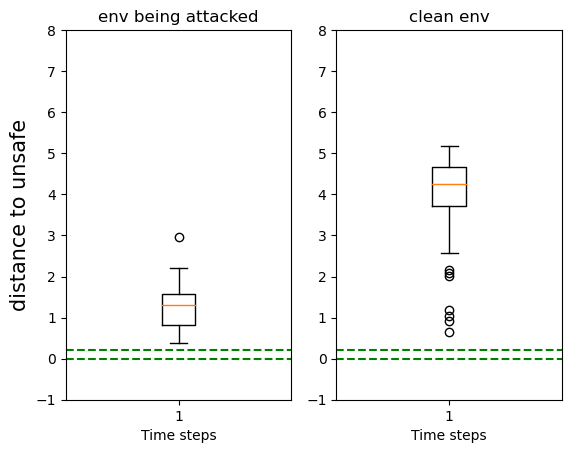

In [13]:
plt.subplot(1, 2, 1)
ave_dist = []
for i in range(50):
    ave_dist.append(sum(obs_dists_list[i]) / len(obs_dists_list[i]))
#     ave_dist.append(min(obs_dists_list[i]))
    # print(obs_dists_list[i])
    # plt.plot(np.arange(len(obs_dists_list[i])), obs_dists_list[i], color='red')
# print(ave_dist)
plt.boxplot(ave_dist)    
plt.ylim((-1, 8))   
plt.axhline(y=0.2, color='g', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')
plt.plot()
plt.xlabel('Time steps')
plt.ylabel('distance to unsafe', fontsize = 15)
plt.title('env being attacked')
# plt.show()


plt.subplot(1, 2, 2)
ave_dist = []
for i in range(50):
    ave_dist.append(sum(clean_obs_dists_list[i]) / len(clean_obs_dists_list[i]))
#     ave_dist.append(min(clean_obs_dists_list[i]))
    # plt.plot(np.arange(len(clean_obs_dists_list[i])), clean_obs_dists_list[i], color='green')
# print(ave_dist)
plt.boxplot(ave_dist)    
plt.ylim((-1, 8))       
plt.axhline(y=0.2, color='g', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')
plt.plot()
plt.xlabel('Time steps')
# plt.ylabel('obstacle distance')
plt.title('clean env')
plt.show()

In [109]:
#  train adv policy to collide with obstacle
reached = []
for k in [10]:
    env = adv_DCEnv()
    env.k = k
    print('Start training with A2C ...')
    # learning_rate = 1e-3, n_steps = 1024, tune these
    adv_model = A2C("MlpPolicy", env, verbose=0)
    adv_model.learn(total_timesteps=300000, progress_bar=False)
    vec_env = adv_model.get_env()
    obs = vec_env.reset()
    env = DCEnv()
    env.k = 160
    state = env.reset()
    dims0 = []
    dims1 = []
    dims2 = []
    euclids = []
    center = env.center
    obstacle = env.center
    num_reached = 0
    for j in range(1000):
        dim0 = []
        dim1 = []
        dim2 = []
        euclid = []
        state = env.reset()
        # Print initial state
        for i in range(30):
            action, _states = adv_model.predict(state, deterministic=True)
            new_state, reward, done, _ = env.step(action)
            dim0.append(state[0])
            dim1.append(state[1])
            dim2.append(state[2])
            dist = np.linalg.norm(state[:3]-center)
            obs_dist = min(np.linalg.norm(state[:3]-obstacle[0]), np.linalg.norm(state[:3]-obstacle[1]))
            euclid.append(dist)
            state = new_state
            if obs_dist <= env.safe_norm_radius:
                break
#             if dist <= 0.5: # stop
#                 num_reached += 1
#                 break
        dims0.append(dim0)
        dims1.append(dim1)
        dims2.append(dim2)
        euclids.append(euclid)
    reached.append(num_reached)
#     print("Total number reached = " + str(num_reached))
print(reached)

Start training with A2C ...
[0]


In [111]:
# adv_model.save('adv_A2C_motor_1.zip')

In [6]:
def black_attack(env, state, model, surro_model,adv_model, epsilon):
    action = surro_model.predict(state)[0]
#     print(action)
    effect = None
    attack = None
    _action = action
    _state = state
    state_range =  np.array([epsilon])

    

    op_action = adv_model.predict(state)[0]
#     op_action = (result.x)
    state = torch.from_numpy(state)
    
    state = state.detach().unsqueeze(0).requires_grad_(True)

    effect = 1000

    for i in range(20):
        
        action = surro_model.policy._predict(state, deterministic=True)[0].requires_grad_(True)
        action = action * 10
        action = action.double().requires_grad_(True)
        # print(action)
        # compute the distance
        loss = (torch.tensor([op_action]) - action).pow(2).sqrt()
        
        # loss = mse(torch.tensor([op_action]).requires_grad_(True), action)
        surro_model.policy.zero_grad()
        loss = loss.double()
        # print(action.dtype)
        loss.backward()
        state_grad = state.grad.detach().squeeze()
        # print(state_grad)
        perturbed_state = state - state_grad.sign() * epsilon * 0.1
        l =  torch.from_numpy(_state) - torch.from_numpy(state_range)
        u = torch.from_numpy(_state) +  torch.from_numpy(state_range)
        perturbed_state = torch.max(torch.min(perturbed_state, u), l)
        
        # print(action_next.detach().numpy()
        state = perturbed_state.detach().requires_grad_(True)
        # print(f'state:{perturbed_state}')
        # print(f'action:{_action}, op_action:{op_action}')
        dist = np.linalg.norm(_state - env.center)
        pertub_dist = np.linalg.norm(state.detach().numpy() - env.center)
        
        if pertub_dist <= dist:
            # 
            if loss <= effect:
                effect = loss
                # print(effect)
                attack = (state.detach().numpy() - _state)[0]
    if attack is None:
        return np.zeros_like(_state)
    else:
        # print(attack)
        return attack     
def Gradient_attack(env, state, model, surro_model, adv_model, epsilon):
    # print(type(state))
    _action = surro_model.predict(state)[0]
    _state = state
    action = surro_model.predict(state)[0]
    state_range = _state / np.linalg.norm(_state) * epsilon * math.sqrt(44)
    # print(surro_model.policy)
    Q = surro_model.critic_target(torch.from_numpy(_state).view(1,-1), torch.from_numpy(action).view(1,-1))[0]
    attack = None
    for i in range(20):
        state = torch.tensor(state)
        # print(state)
        state.requires_grad_(True)

        Q_cur = surro_model.critic_target(state.view(1,-1), torch.from_numpy(action).view(1, -1))[0]
        # print(Q_cur)
        model.policy.zero_grad()

        Q_cur.backward()
        grad = state.grad
        grad_dir = grad.sign() * epsilon * 0.1

        state = state - grad_dir

        state_range = np.array([epsilon])
        
        l = torch.from_numpy(_state) - torch.from_numpy(state_range)
        u = torch.from_numpy(_state) + torch.from_numpy(state_range)
        state = torch.max(torch.min(state, u), l)
        action = surro_model.predict(state.detach().numpy())[0]
        Q_adv = surro_model.critic(torch.from_numpy(_state).view(1, -1), torch.from_numpy(action).view(1, -1))[0]
        dist = np.linalg.norm(_state - env.center)
        pertub_dist = np.linalg.norm(state.detach().numpy() - env.center)
        if Q_adv <= Q and pertub_dist <= dist:
            Q = Q_adv
            attack = (state.detach().numpy() - _state)
    if attack is not None:
        # print(attack)
        return attack

    else:
        # print("no attack")
        return np.zeros_like(_state)

import torch.distributions.kl as kl
from scipy.optimize import minimize, Bounds, LinearConstraint, NonlinearConstraint, root

def MAD(env, obs, model, surro_model, adv_model, epsilon):
    _state = obs
    state_range = np.array([epsilon])
    dis = model.policy.get_distribution(torch.from_numpy(obs).view(1, -1))
    p = dis.distribution
    # print(p.loc)
    def fun(x):
        dis2 = model.policy.get_distribution(torch.from_numpy(obs + x).view(1, -1))
        # print(dis2)
        q = dis2.distribution
        # print(q)
        return -kl.kl_divergence(p, q).sum().detach().numpy()

    x_start = np.zeros_like(obs)
    # non_linear_eq = lambda x: (np.max(np.abs(x))) - epsilon
    bo = np.zeros_like(_state) + epsilon
    bound = Bounds(-bo, bo)
    result = minimize(fun, x_start, method='trust-constr', bounds=bound)
    op_attack = (result.x)
    # print(op_attack)
    return op_attack

In [19]:

# test white, grey, black box attack
norm = float('inf')
res_list = []
epsilon = 10
policy = None
args = None

def white(env, model, surro_model,adv_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    for j in range(total_epoch):
        state = env.reset()
        # clean_state = clean_env.reset()
        for i in range( 2* env.step_const):
            attack = white_attack(env, state, model, surro_model, adv_model, epsilon)
            
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            state = new_state
            # pertub_action_list.append(pertub_action[0])
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                break
            if done:
                env.reset()
    print(f'white attack violation:{number_violate}, reach:{num_reached}')

def black(env, model, surro_model,adv_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    for j in range(total_epoch):
        state = env.reset()
        # clean_state = clean_env.reset()
        for i in range( 2* env.step_const):
            attack = black_attack(env, state, model, surro_model, adv_model, epsilon)
        
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            # pertub_action_list.append(pertub_action[0])
            state = new_state
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                break
            if done:
                env.reset()
    print(f'black attack violation:{number_violate}, reach:{num_reached}')

def grey_s(env, model, surro_model,adv_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    for j in range(total_epoch):
        state = env.reset()
        # clean_state = clean_env.reset()
        for i in range( 2 * env.step_const):
            attack = white_attack(env, state, model=surro_model, surro_model=surro_model, adv_model=adv_model, epsilon=epsilon)
        
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            state = new_state
            # pertub_action_list.append(pertub_action[0])
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                break
            if done:
                env.reset()
    print(f'grey_s attack violation:{number_violate}, reach:{num_reached}')
    
def gradient(env, model, surro_model,adv_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    for j in range(total_epoch):
        state = env.reset()
        for i in range(2 * env.step_const):
            attack = Gradient_attack(env, state, model=model, surro_model=model, adv_model=adv_model, epsilon=epsilon)
        
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            state = new_state
            # pertub_action_list.append(pertub_action[0])
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                break
            if done:
                env.reset()
    print(f'GA attack violation:{number_violate}, reach:{num_reached}')
    
def grey_c(env, model, surro_model,adv_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    for j in range(total_epoch):
        state = env.reset()
        for i in range(2 * env.step_const):
            attack = black_attack(env, state, model=model, surro_model=model, adv_model=adv_model, epsilon=epsilon)
        
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            state = new_state
            # pertub_action_list.append(pertub_action[0])
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                break
            if done:
                env.reset()
    print(f'grey_c attack violation:{number_violate}, reach:{num_reached}')
env = DCEnv()
adv_env = adv_DCEnv()
surro_model = SAC.load("SAC_motor_1.zip", env=env)
model = SAC.load('surro_SAC_motor_1.zip', env=env)
adv_model = A2C.load('adv_A2C_motor.zip', env=adv_env)
total_epoch = 250
for epsilon in [0.01, 0.05, 0.10, 0.15]:
     print(epsilon)
     # white(env, model, surro_model,adv_model, epsilon, total_epoch)
     # black(env, model, surro_model,adv_model, epsilon, total_epoch)
     # grey_c(env, model, surro_model,adv_model, epsilon, total_epoch)
     # grey_s(env, model, surro_model,adv_model, epsilon, total_epoch)
     gradient(env=env,  model=model, surro_model=surro_model, adv_model=adv_model, epsilon=epsilon, total_epoch= total_epoch)
     print('++++++++++')

0.01


C:\Users\sjiang5\AppData\Local\Temp\ipykernel_16928\1627012471.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state)


GA attack violation:28, reach:204
++++++++++
0.05
GA attack violation:32, reach:206
++++++++++
0.1
GA attack violation:40, reach:188
++++++++++
0.15
GA attack violation:39, reach:179
++++++++++


In [48]:
def laa(env, model, surro_model,adv_model, baseline_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    grey_c_dist_list = []
    for j in range(total_epoch):
        state = env.reset()
        dist_list = []
        for i in range(2 * env.step_const):
            attack = black_attack(env, state, model=model, surro_model=surro_model, adv_model=baseline_model, epsilon=epsilon)
        
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            dist_list.append(obs_dist)
            state = new_state
            # pertub_action_list.append(pertub_action[0])
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                grey_c_dist_list.append(dist_list)
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                grey_c_dist_list.append(dist_list)
                break
            if done:
                env.reset()
    print(f'laa attack violation:{number_violate}, reach:{num_reached}')
def MAD(env, obs, model, surro_model, adv_model, epsilon):
        action = model.predict(obs, deterministic=True)[0]
        # print(action)
        effect = None
        attack = None
        _action = action
        _state = obs
        state_range = np.array([epsilon])

        def fun(x):
            u = model.predict(x + _state, deterministic=True)[0]
            result = np.sum(np.power(action - u, 2)) * (-1)
            return result

        x_start = np.zeros_like(_state)
        lim = np.zeros_like(_state) + epsilon

        bounds = Bounds(-lim, lim)

        result = minimize(fun, x_start, method='trust-constr', bounds=bounds)
        # print(result.x)
        op_action = (result.x)

        op_action = (result.x)
        return op_action

def mad(env, model, surro_model,adv_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    for j in range(total_epoch):
        state = env.reset()
        for i in range(2 * env.step_const):
            attack = MAD(env, state, model=model, surro_model=model, adv_model=adv_model, epsilon=epsilon)
        
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            state = new_state
            # pertub_action_list.append(pertub_action[0])
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                break
            if done:
                env.reset()
    print(f'mad attack violation:{number_violate}, reach:{num_reached}')
env = DCEnv()
adv_env = adv_DCEnv()
surro_model = SAC.load("SAC_motor_1.zip", env=env)
model = SAC.load('surro_SAC_motor_1.zip', env=env)
adv_model = A2C.load('adv_A2C_motor.zip', env=adv_env)
baseline_model = SAC.load('baseline_dcmotor_model.zip', env=env)
total_epoch = 250
for epsilon in [0.01, 0.05, 0.1, 0.15]:
     print(epsilon)
     # mad(env, model, surro_model,adv_model, epsilon, total_epoch)
     laa(env, model, surro_model,adv_model, baseline_model, epsilon, total_epoch)
     print('++++++++++')
     


0.01
laa attack violation:32, reach:206
++++++++++
0.05
laa attack violation:22, reach:217
++++++++++
0.1
laa attack violation:42, reach:193
++++++++++
0.15
laa attack violation:53, reach:167
++++++++++


0.15


C:\Users\sjiang5\anaconda3\envs\example\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
C:\Users\sjiang5\anaconda3\envs\example\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
  warnings.warn(


black attack violation:30, reach:63


C:\Users\sjiang5\anaconda3\envs\example\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


white attack violation:28, reach:58
grey_c attack violation:17, reach:74


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grey_s attack violation:22, reach:60
++++++++++


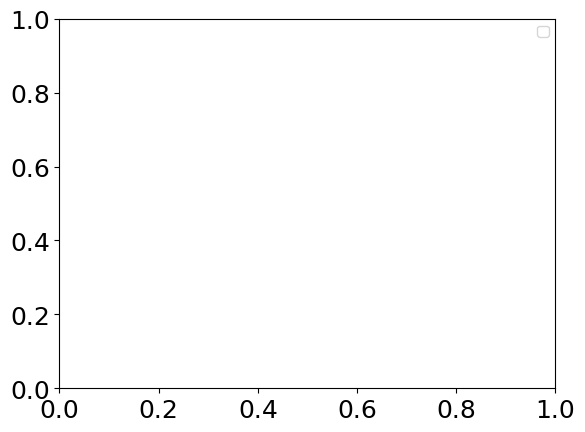

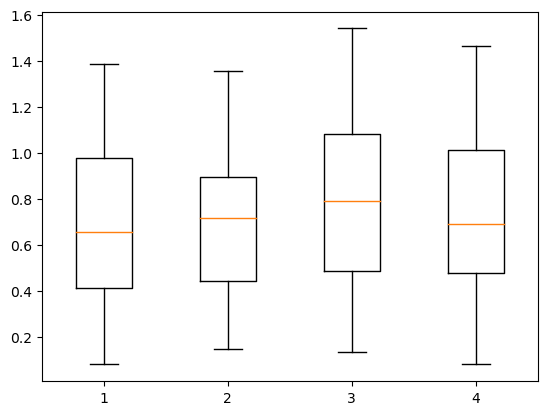

In [31]:
# draw trajactory

# test white, grey, black box attack
norm = float('inf')
res_list = []
epsilon = 10
policy = None
args = None

def white(env, model, surro_model,adv_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    white_dist_list = []
    for j in range(total_epoch):
        state = env.reset()
        dist_list = []
        # clean_state = clean_env.reset()
        for i in range( 2* env.step_const):
            attack = white_attack(env, state, model, surro_model, adv_model, epsilon)
            
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            dist_list.append(obs_dist)
            state = new_state
            # pertub_action_list.append(pertub_action[0])
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                white_dist_list.append(dist_list)
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                white_dist_list.append(dist_list)
                break
            if done:
                env.reset()
    print(f'white attack violation:{number_violate}, reach:{num_reached}')
    return white_dist_list

def black(env, model, surro_model,adv_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    black_dist_list = []
    for j in range(total_epoch):
        state = env.reset()
        # clean_state = clean_env.reset()
        dist_list = []
        for i in range( 2* env.step_const):
            attack = black_attack(env, state, model, surro_model, adv_model, epsilon)
        
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            dist_list.append(obs_dist)
            # pertub_action_list.append(pertub_action[0])
            state = new_state
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                black_dist_list.append(dist_list)
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                black_dist_list.append(dist_list)
                break
            if done:
                env.reset()
    print(f'black attack violation:{number_violate}, reach:{num_reached}')
    return black_dist_list

def grey_s(env, model, surro_model,adv_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    grey_s_dist_list = []
    for j in range(total_epoch):
        state = env.reset()
        # clean_state = clean_env.reset()
        dist_list = []
        for i in range( 2 * env.step_const):
            attack = white_attack(env, state, model=surro_model, surro_model=surro_model, adv_model=adv_model, epsilon=epsilon)
        
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            dist_list.append(obs_dist)
            state = new_state
            # pertub_action_list.append(pertub_action[0])
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                grey_s_dist_list.append(dist_list)
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                grey_s_dist_list.append(dist_list)
                break
            if done:
                env.reset()
    print(f'grey_s attack violation:{number_violate}, reach:{num_reached}')
    return grey_s_dist_list
    
def gradient(env, model, surro_model,adv_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    for j in range(total_epoch):
        state = env.reset()
        for i in range(2 * env.step_const):
            attack = Gradient_attack(env, state, model=model, surro_model=model, adv_model=adv_model, epsilon=epsilon)
        
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            state = new_state
            # pertub_action_list.append(pertub_action[0])
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                break
            if done:
                env.reset()
    print(f'GA attack violation:{number_violate}, reach:{num_reached}')
    
def grey_c(env, model, surro_model,adv_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    grey_c_dist_list = []
    for j in range(total_epoch):
        state = env.reset()
        dist_list = []
        for i in range(2 * env.step_const):
            attack = black_attack(env, state, model=model, surro_model=model, adv_model=adv_model, epsilon=epsilon)
        
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            dist_list.append(obs_dist)
            state = new_state
            # pertub_action_list.append(pertub_action[0])
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                grey_c_dist_list.append(dist_list)
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                grey_c_dist_list.append(dist_list)
                break
            if done:
                env.reset()
    print(f'grey_c attack violation:{number_violate}, reach:{num_reached}')
    return grey_s_dist_list
def laa(env, model, surro_model,adv_model, baseline_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    grey_c_dist_list = []
    for j in range(total_epoch):
        state = env.reset()
        dist_list = []
        for i in range(2 * env.step_const):
            attack = laa(env, state, model=model, surro_model=model, adv_model=adv_model, baseline_model=baseline_model, epsilon=epsilon)
        
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            dist_list.append(obs_dist)
            state = new_state
            # pertub_action_list.append(pertub_action[0])
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                grey_c_dist_list.append(dist_list)
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                grey_c_dist_list.append(dist_list)
                break
            if done:
                env.reset()
    print(f'laa attack violation:{number_violate}, reach:{num_reached}')
env = DCEnv()
adv_env = adv_DCEnv()
surro_model = SAC.load("SAC_motor_1.zip", env=env)
model = SAC.load('surro_SAC_motor_1.zip', env=env)
adv_model = A2C.load('adv_A2C_motor.zip', env=adv_env)
total_epoch = 100
for epsilon in [0.15]:
     print(epsilon)
     black_dist_list = black(env=env,  model=model, surro_model=surro_model, adv_model=adv_model, epsilon=epsilon, total_epoch= total_epoch)
     white_dist_list = white(env=env, model=model, surro_model=surro_model, adv_model=adv_model,
                                                 epsilon=epsilon, total_epoch=total_epoch)

     grey_c_dist_list = grey_c(env=env,  model=model, surro_model=surro_model, adv_model=adv_model, epsilon=epsilon , total_epoch= total_epoch)
     grey_s_dist_list = grey_s(env=env,  model=model, surro_model=surro_model, adv_model=adv_model, epsilon=epsilon, total_epoch= total_epoch)
     # gradient(env=env,  model=model, surro_model=surro_model, adv_model=adv_model, epsilon=epsilon, total_epoch= total_epoch)
     print('++++++++++')
     
white_ave = []
black_ave = []
grey_c_ave = []
grey_s_ave = []
# for i in range(0, len(white_dist_list)):
#     white_ave.append(np.sum(white_dist_list[i])/len(white_dist_list[i])  )
# for i in range(0, len(black_dist_list)):
#     black_ave.append(np.sum(black_dist_list[i])/len(black_dist_list[i])  )
# for i in range(0, len(grey_c_dist_list)):
#     grey_c_ave.append(np.sum(grey_c_dist_list[i])/len(grey_c_dist_list[i]) )
# for i in range(0, len(grey_s_dist_list)):
#     grey_s_ave.append(np.sum(grey_s_dist_list[i])/len(grey_s_dist_list[i]) )
for i in range(0, len(white_dist_list)):
    white_ave.append(np.min(white_dist_list[i])  )
for i in range(0, len(black_dist_list)):
    black_ave.append(np.min(black_dist_list[i]))
for i in range(0, len(grey_c_dist_list)):
    grey_c_ave.append(np.min(grey_c_dist_list[i]) )
for i in range(0, len(grey_s_dist_list)):
    grey_s_ave.append(np.min(grey_s_dist_list[i]))



plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

plt.legend()
plt.show()
# plt.savefig('dcmotor_stealthy.png', dpi=500)
data = [white_ave, grey_c_ave, grey_s_ave, black_ave]
plt.boxplot(data)
plt.show()


with open(r'dcmotor_white_dist.txt', 'w') as fp:
    for item in white_ave:
        # write each item on a new line
        fp.write("%s\n" % item)
with open(r'dcmotor_black_dist.txt', 'w') as fp:
    for item in black_ave:
        # write each item on a new line
        fp.write("%s\n" % item)

with open(r'dcmotor_grey_c_dist.txt', 'w') as fp:
    for item in grey_c_ave:
        # write each item on a new line
        fp.write("%s\n" % item)
with open(r'dcmotor_grey_s_dist.txt', 'w') as fp:
    for item in grey_s_ave:
        # write each item on a new line
        fp.write("%s\n" % item)
     

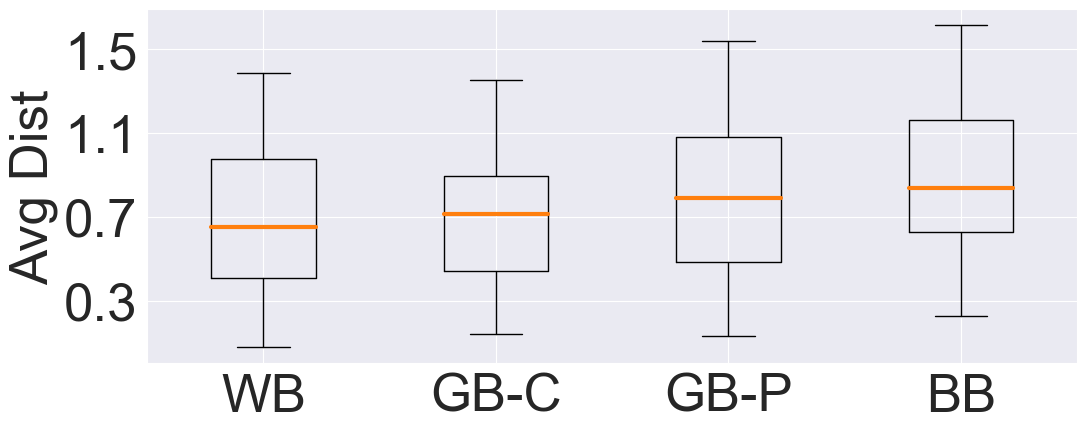

In [4]:
import matplotlib.pyplot as plt
import numpy as np
white_ave = []
black_ave = []
grey_c_ave = []
grey_s_ave = []

with open(r'dcmotor_white_dist.txt', 'r') as fp:
    white_ave = [float(x)  for x in fp.read().split()]
    # print(white_ave)

with open(r'dcmotor_black_dist.txt', 'r') as fp:
    black_ave = [float(x)+0.15 for x in fp.read().split()]

with open(r'dcmotor_grey_c_dist.txt', 'r') as fp:
    grey_c_ave = [float(x) for x in fp.read().split()]

with open(r'dcmotor_grey_s_dist.txt', 'r') as fp:
    grey_s_ave = [float(x) for x in fp.read().split()]

# fig = plt.figure()
#
# fig.set_figheight(3)
# fig.set_figwidth(9)


fig, ax = plt.subplots()
fig.set_figheight(4.6)
fig.set_figwidth(12)
plt.yticks(fontsize=38)
plt.xticks(fontsize=38)
ax.yaxis.set_ticks(np.arange(-0.1, 2.4, 0.4))
data = [white_ave, grey_c_ave, grey_s_ave, black_ave]
B = ax.boxplot(data, medianprops=dict(linewidth=3), labels=("WB","GB-C","GB-P", 'BB'))
plt.ylabel('Avg Dist', fontsize=38)
middle = [item.get_ydata()[1] for item in B['medians']]


# plt.legend()
plt.savefig('box_dcmotor.pdf', bbox_inches='tight', dpi=500)

plt.show()




In [38]:
class baseline_DCEnv(gym.Env):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }

    def __init__(self, render_mode: Optional[str] = None, g=10.0):
        super(baseline_DCEnv, self).__init__()
        self.max_speed = -10
        self.max_torque = 10
        self.dt = 0.05

        self.render_mode = render_mode

        self.screen_dim = 500
        self.screen = None
        self.clock = None
        self.isopen = True
        self.center = np.array([math.pi / 3.0 * 2, 0, 0])
        self.obstacle = np.array([[math.pi / 4.0, 0, 0], [math.pi / 8.0, 0, 0]])
        
        count = 0
        J = 0.01
        b = 0.1
        K = 0.01
        R = 1
        L = 0.5
        self.A = np.array([[0, 1, 0],
         [0, -b / J, K / J],
         [0, -K / L, -R / L]])
        self.A_dim = len(self.A)
        self.B = np.array([[0], [0], [1 / L]])
        self.xmeasure = 0
        self.attacked_element_idx = 0
        self.C = np.array([[1, 0, 0]])
        self.D = np.array([[0]])
        self.Q = np.eye(self.A_dim)
        self.R = np.array([[1]])
        self.dt = 0.2
        self.x_ref = np.array([[0], [0], [0]]) # 4th dim is remaining steps
        # store current trace
        self.cache1 = []
        self.cache2 = []
        self.cache3 = []
        self.x0 = np.copy(self.x_ref)
        self.u_upbound_tuned = np.array([[10]])
        # ball radius
        self.target_norm_radius = 0.6 # norm ball radius of target, tune this
        self.safe_norm_radius = 0.5 # norm ball radius of safe, tune this
        self.total_time = 120
        # step number
        self.steps = 0
        self.u_lowbound = None
        # store training traces
        self.state_array_1 = []
        self.state_array_2 = []
        self.state_array_3 = []
        self.caches = []
        self.reward_cache = [] # cache distances to target norm ball center
        self.avoid_reward_cache = [] # cache distances to obstacles norm ball center
        self.final_reward_cache = [] # cache final reward
        # How long should this trace be, i.e. deadline
        self.step_const = 50
        # Maximum reward from each trace
        self.max_reward_list = []
        self.quality_list = []
        self.total_steps = 0
        self.step_history = []
        self.sysc = ss(self.A, self.B, self.C, self.D)
        self.sysd = c2d(self.sysc, self.dt)
        
        high = np.array(self.x_ref.flatten(), dtype=np.float32)
        self.action_space = spaces.Box(
            low=-self.max_torque, high=self.max_torque, shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)
        self.reached = False
        self.k = 20
    def step(self, u):
        
        # simulate next step and get measurement
        self.steps += 1
        self.total_steps += 1
        terminated = False
        dt = self.dt
        u = np.clip(u, -self.max_torque, self.max_torque)[0]
        self.last_u = u 
        costs = 1
        yout, T, xout = lsim(self.sysc, self.last_u, [0, self.dt], self.xmeasure)
        self.xmeasure = xout[-1]
        
        # calculate euclidean distance and update reward cache
        dist = np.linalg.norm(self.xmeasure - self.center)
        state = self.xmeasure
        obs_dist = min(np.linalg.norm(state[:3] - env.obstacle[0]), np.linalg.norm(state[:3] - env.obstacle[1]))
        reward = self.target_norm_radius - dist
        obs_reward = obs_dist-self.safe_norm_radius
        
        self.reward_cache.append(reward)
        self.avoid_reward_cache.append(obs_reward)
        # quantitative semantics
        # reach reward, encourage reaching target
        if self.steps < 10:
            reach_reward = max(self.reward_cache)
        else:
            reach_reward = max(self.reward_cache[-10:])
        if self.steps < 10:
            avoid_reward = min(self.avoid_reward_cache)
        else:
            avoid_reward = min(self.avoid_reward_cache[-10:])          
        final_reward = -reward
        # if dist <= self.target_norm_radius:
        #     final_reward = 10 # this gives 39/50 sucess with reach+approach+avoid
        # 
        self.final_reward_cache.append(final_reward)
        
        # update cached memory
        self.state = self.xmeasure
        self.state_array_1.append(self.state[0])
        self.state_array_2.append(self.state[1])
        self.state_array_3.append(self.state[2])
        self.cache1.append(self.state[0])
        self.cache2.append(self.state[1])
        self.cache3.append(self.state[2])
        self.last_dist = dist
        # If this is the last step, reset the state
        if self.steps == self.step_const or obs_dist<=self.safe_norm_radius:
            self.max_reward_list.append(max(self.final_reward_cache)) # use max final reward to measure episodes
            self.step_history.append(self.total_steps)
            self.quality_list.append(sum(self.final_reward_cache))
            terminated = True
            # self.reset()
            
#         # If within target norm ball, early terminate
#         if dist <= self.target_norm_radius:
#             terminated = True
#             self.reset()
        
        # Return next state, reward, done, info
        return self._get_obs(), final_reward, terminated, {}
        
    def reset(self):
        self.state = np.array([random.random()*math.pi - 1, random.random()*2-1, random.random()*20-10])
        self.reward_cache = []
        self.final_reward_cache = []
        self.steps=0
        self.caches.append(self.cache1)
        self.caches.append(self.cache2)
        self.caches.append(self.cache3)
        self.cache1 = []
        self.cache2 = []
        self.cache3 = []
        self.xmeasure = self.state
        # random # of steps for this trace
        self.step_const = self.k # deadline range
        self.reached = False
        return np.array(self.state) # return something matching shape
    
    def _get_obs(self):
        current_state = list(self.state)
        return np.array(current_state)
    
    def render(self):
        return
    
    def close(self):
        if self.screen is not None:
            import pygame
            pygame.display.quit()
            pygame.quit()
            self.isopen = False

In [46]:
reached = []
env = baseline_DCEnv()
# model = A2C.load('surro_A2C_motor_1.zip', env=env)
for k in [10]:
    env = DCEnv()
    env.k = k
    print('Start training with PPO ...')
    # baseline_model = SAC("MlpPolicy", env, verbose=0)
    baseline_model = SAC.load('baseline_dcmotor_model.zip', env= env)
    baseline_model.learn(total_timesteps=500000, progress_bar=False)
baseline_model.save('baseline_dcmotor_model.zip')
print('done')
#     vec_env = baseline_model.get_env()
#     obs = vec_env.reset()
#     env = DCEnv()
# #     env.k = 160
#     state = env.reset()
#     dims0 = []
#     dims1 = []
#     dims2 = []
#     euclids = []
#     center = env.center
# #     obstacle = np.array([math.pi / 4.0, 0, 0])
#     obstacle = env.obstacle
#     num_reached = 0
#     for j in range(1000):
#         dim0 = []
#         dim1 = []
#         dim2 = []
#         euclid = []
#         state = env.reset()
#         # Print initial state
#         for i in range(50):
#             action, _states = baseline_model.predict(state, deterministic=True)
#             new_state, reward, done, _ = env.step(action)
#             dim0.append(state[0])
#             dim1.append(state[1])
#             dim2.append(state[2])
#             dist = np.linalg.norm(state[:3]-center)
#             obs_dist = min(np.linalg.norm(state[:3] - obstacle[0]), np.linalg.norm(state[:3] - obstacle[1]))
#             euclid.append(dist)
#             state = new_state
#             if obs_dist <= env.safe_norm_radius:
#                 break
#             if dist <= env.target_norm_radius: # stop
#                 num_reached += 1
#                 break
#             if done:
#                 env.reset()
#         dims0.append(dim0)
#         dims1.append(dim1)
#         dims2.append(dim2)
#         euclids.append(euclid)
#     reached.append(num_reached)
#     print("Total number reached = " + str(num_reached))


Start training with PPO ...
done
